In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from six import StringIO 
from IPython.display import Image as Img  
import pydotplus
import graphviz
from pydot import graph_from_dot_data
import pydot

In [175]:
from fastseg import MobileV3Large

In [176]:
model = MobileV3Large(num_classes=19, use_aspp=True, num_filters=256)
model = model.from_pretrained(num_filters=256)

Loading pretrained model mobilev3large-lraspp with F=256...


In [177]:
img = Image.open("../data/utube/Kochi 4K _ Driving from Kakkanad to Kaloor by sunset 24-41 screenshot.png")
labels = model.predict_one(img)

In [178]:
labels.shape

(1080, 1920)

In [179]:
labels

array([[10, 10, 10, ...,  5,  5,  5],
       [10, 10, 10, ...,  5,  5,  5],
       [10, 10, 10, ...,  5,  5,  5],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [180]:
classes, counts = np.unique(labels, return_counts=True)
classes, counts, counts.sum()

(array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18]),
 array([571909,  19333, 567996,  15262,  32790,  18517,   1460, 339605,
         42222, 307525,  13580,  10107,  76213,  16147,  19551,     13,
         20035,   1335]),
 2073600)

In [181]:
class_names = ["road", "sidewalk", "building", "wall", "fence", "pole", "traffic_light", "traffic_sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck", "bus", "train", "motorcycle", "bicycle"]
len(class_names)

19

In [182]:
img_class_counts = {}

In [183]:
img_dir = "../data/utube"

In [184]:
# for img_path in os.listdir(img_dir):
#     print(f"Processing image {img_path}")
#     img = Image.open(os.path.join(img_dir, img_path))
#     labels = model.predict_one(img)
#     _, counts = np.unique(labels, return_counts=True)
#     n_pixels = labels.size
#     counts = counts/ n_pixels
#     img_class_counts[img_path] = counts

In [5]:
with open("img_class_counts.pkl", 'rb') as f:
    img_class_counts = pickle.load(f)

In [6]:
class_names = ["road", "sidewalk", "building", "wall", "fence", "pole", "traffic_light", "traffic_sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck", "bus", "train", "motorcycle", "bicycle"]
len(class_names)

19

In [7]:
relevant_classes = ["road", "sidewalk", "building", "vegetation", "terrain", "sky"]
relevant_class_ids = []

for class_name in relevant_classes:
    relevant_class_ids.append(class_names.index(class_name))

relevant_class_ids

[0, 1, 2, 8, 9, 10]

In [8]:
img_class_counts["Kochi 4K _ Driving from Kakkanad to Kaloor by sunset 24-41 screenshot.png"][relevant_class_ids]

array([0.27580488, 0.0093234 , 0.27391782, 0.02036169, 0.14830488,
       0.006549  ])

In [9]:
relevant_img_class_counts = {img:img_count[relevant_class_ids] for img, img_count in img_class_counts.items()}
relevant_img_class_counts

{'#Cochin airport to Kochi city drive, August 2021 _ #kochiairport 15-57 screenshot.png': array([0.28924238, 0.03632957, 0.08887635, 0.0069213 , 0.10115837,
        0.00716291]),
 '#Cochin airport to Kochi city drive, August 2021 _ #kochiairport 2-13 screenshot.png': array([0.39467496, 0.01927662, 0.18223187, 0.05135995, 0.11241175,
        0.0034322 ]),
 '#Cochin airport to Kochi city drive, August 2021 _ #kochiairport 6-53 screenshot.png': array([0.21039834, 0.0055353 , 0.21603299, 0.05899016, 0.09765529,
        0.00052132]),
 '#Cochin airport to Kochi city drive, August 2021 _ #kochiairport 8-1 screenshot.png': array([0.247174  , 0.00705102, 0.34315297, 0.04089892, 0.17496094,
        0.01072868]),
 '#Cochin airport to Kochi city drive, August 2021 _ #kochiairport 8-11 screenshot.png': array([0.23334008, 0.00585214, 0.37459346, 0.13638744, 0.04835262,
        0.10848283]),
 '#Cochin airport to Kochi city drive, August 2021 _ #kochiairport 9-43 screenshot.png': array([0.31637539, 0.

In [10]:
feature_names = ["frac_"+name for name in relevant_classes]
feature_names

['frac_road',
 'frac_sidewalk',
 'frac_building',
 'frac_vegetation',
 'frac_terrain',
 'frac_sky']

In [11]:
dataset = pd.DataFrame(list(relevant_img_class_counts.values()), columns=feature_names)

In [12]:
dataset.head()

,frac_road,frac_sidewalk,frac_building,frac_vegetation,frac_terrain,frac_sky
0,0.289242,0.036330,0.088876,0.006921,0.101158,0.007163
1,0.394675,0.019277,0.182232,0.051360,0.112412,0.003432
2,0.210398,0.005535,0.216033,0.058990,0.097655,0.000521
3,0.247174,0.007051,0.343153,0.040899,0.174961,0.010729
4,0.233340,0.005852,0.374593,0.136387,0.048353,0.108483


In [13]:
dataset["img_name"] = list(relevant_img_class_counts.keys())
dataset.head()

,frac_road,frac_sidewalk,frac_building,frac_vegetation,frac_terrain,frac_sky,img_name
0,0.289242,0.036330,0.088876,0.006921,0.101158,0.007163,"#Cochin airport to Kochi city drive, August 20..."
1,0.394675,0.019277,0.182232,0.051360,0.112412,0.003432,"#Cochin airport to Kochi city drive, August 20..."
2,0.210398,0.005535,0.216033,0.058990,0.097655,0.000521,"#Cochin airport to Kochi city drive, August 20..."
3,0.247174,0.007051,0.343153,0.040899,0.174961,0.010729,"#Cochin airport to Kochi city drive, August 20..."
4,0.233340,0.005852,0.374593,0.136387,0.048353,0.108483,"#Cochin airport to Kochi city drive, August 20..."


In [14]:
dataset = dataset[["img_name"] + feature_names]
dataset.head()

,img_name,frac_road,frac_sidewalk,frac_building,frac_vegetation,frac_terrain,frac_sky
0,"#Cochin airport to Kochi city drive, August 20...",0.289242,0.036330,0.088876,0.006921,0.101158,0.007163
1,"#Cochin airport to Kochi city drive, August 20...",0.394675,0.019277,0.182232,0.051360,0.112412,0.003432
2,"#Cochin airport to Kochi city drive, August 20...",0.210398,0.005535,0.216033,0.058990,0.097655,0.000521
3,"#Cochin airport to Kochi city drive, August 20...",0.247174,0.007051,0.343153,0.040899,0.174961,0.010729
4,"#Cochin airport to Kochi city drive, August 20...",0.233340,0.005852,0.374593,0.136387,0.048353,0.108483


In [15]:
city_walkability_scores = {"Bangalore": 0.63, "Chennai": 0.77, "Kochi": 0.57, "Kolkata": 0.81, "Mumbai": 0.85,
                            "Varanasi": 0.33, "Shimla": 0.22, "Bhubaneswar": 0.28}

In [16]:
img_walkability_bins = {}
cities = city_walkability_scores.keys()

for img in relevant_img_class_counts.keys():
    city = [c for c in cities if c.lower() in img.lower()][0]
    img_walkability_bins[img] = int(city_walkability_scores[city] // 0.2)

img_walkability_bins

{'#Cochin airport to Kochi city drive, August 2021 _ #kochiairport 15-57 screenshot.png': 2,
 '#Cochin airport to Kochi city drive, August 2021 _ #kochiairport 2-13 screenshot.png': 2,
 '#Cochin airport to Kochi city drive, August 2021 _ #kochiairport 6-53 screenshot.png': 2,
 '#Cochin airport to Kochi city drive, August 2021 _ #kochiairport 8-1 screenshot.png': 2,
 '#Cochin airport to Kochi city drive, August 2021 _ #kochiairport 8-11 screenshot.png': 2,
 '#Cochin airport to Kochi city drive, August 2021 _ #kochiairport 9-43 screenshot.png': 2,
 '4K Drive _ Sector 5 _ Kolkata 2-3 screenshot.png': 4,
 '4K Drive in Esplanade, Park Street, Camac Street, Kolkata _ (formerly Calcutta) @Distance between 0-58 screenshot.png': 4,
 '4K Drive in Esplanade, Park Street, Camac Street, Kolkata _ (formerly Calcutta) @Distance between 1-21 screenshot.png': 4,
 '4K Drive in Esplanade, Park Street, Camac Street, Kolkata _ (formerly Calcutta) @Distance between 2-18 screenshot.png': 4,
 '4K Drive in Esp

In [17]:
dataset["label"] = list(img_walkability_bins.values())

In [18]:
dataset.head()

,img_name,frac_road,frac_sidewalk,frac_building,frac_vegetation,frac_terrain,frac_sky,label
0,"#Cochin airport to Kochi city drive, August 20...",0.289242,0.036330,0.088876,0.006921,0.101158,0.007163,2
1,"#Cochin airport to Kochi city drive, August 20...",0.394675,0.019277,0.182232,0.051360,0.112412,0.003432,2
2,"#Cochin airport to Kochi city drive, August 20...",0.210398,0.005535,0.216033,0.058990,0.097655,0.000521,2
3,"#Cochin airport to Kochi city drive, August 20...",0.247174,0.007051,0.343153,0.040899,0.174961,0.010729,2
4,"#Cochin airport to Kochi city drive, August 20...",0.233340,0.005852,0.374593,0.136387,0.048353,0.108483,2


In [28]:
X = dataset.drop(columns=["img_name", "label"])
y = dataset["label"]
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # increase test size

In [30]:
X_train.shape, X_test.shape

((151, 6), (38, 6))

In [31]:
model = DecisionTreeClassifier(random_state=42, max_depth=4) # tune max_depth

In [32]:
model.fit(X_train, y_train)
# model.fit(X_test, y_test)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [33]:
model.score(X_test, y_test)

0.5526315789473685

In [34]:
model.tree_.compute_feature_importances(normalize=False)

array([0.07973453, 0.06390051, 0.05283938, 0.03376507, 0.01109487,
       0.0078076 ])

In [35]:
feature_cols = X.columns
feature_cols

Index(['frac_road', 'frac_sidewalk', 'frac_building', 'frac_vegetation',
       'frac_terrain', 'frac_sky'],
      dtype='object')

In [36]:
feat_imp_dict = dict(zip(feature_cols, model.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'Feature Importance'}, inplace = True)
feat_imp.sort_values(by=['Feature Importance'], ascending=False).head()

,Feature Importance
frac_road,0.320037
frac_sidewalk,0.256482
frac_building,0.212085
frac_vegetation,0.135525
frac_terrain,0.044532


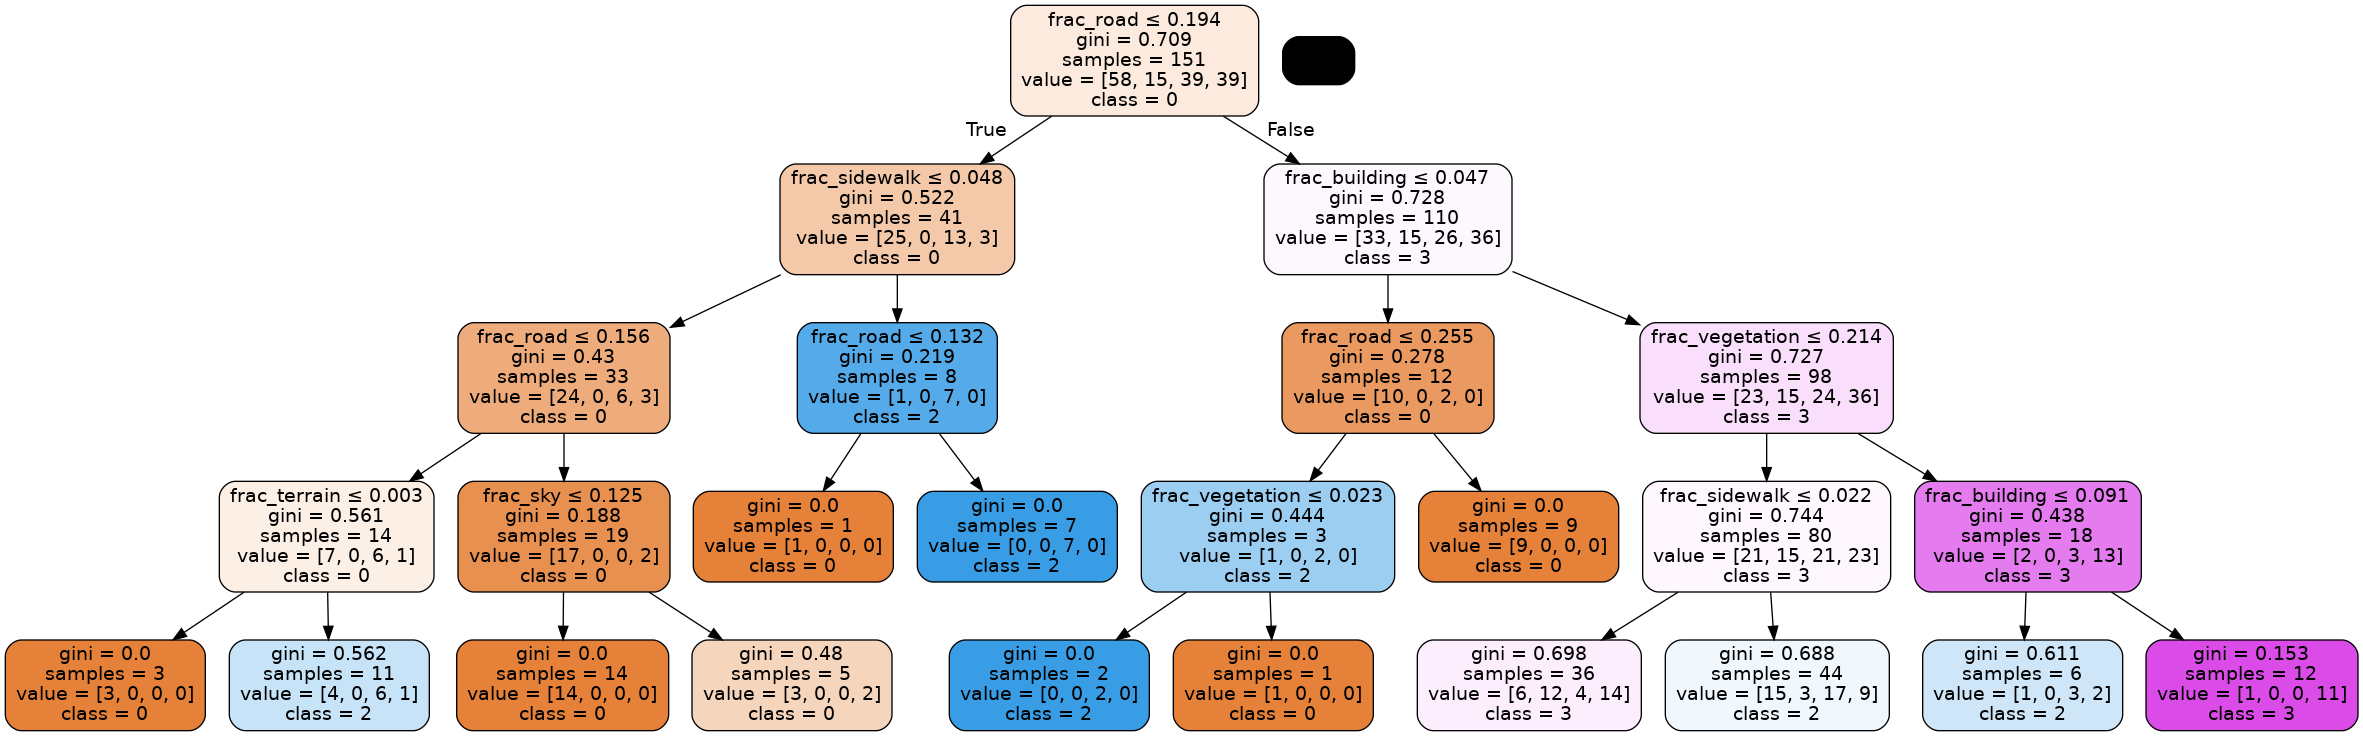

In [37]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols, class_names=['0', '1', '2', '3', '4']) # change class_names to ['0', '1', '2', '3', '4']
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Img(graph.create_png())